# Landmark Classifier Training

Train a classifier head on frozen CLIP embeddings for landmark classification.


## Part 1: Setup & Embedding Extraction

In [34]:
# Cell 1: Imports

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
import json
from torchvision import transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

In [35]:
# Cell 2: Configuration

DATA_DIR = Path(".")
IMAGE_DIR = DATA_DIR / "landmark_images"
EMBEDDING_DIR = DATA_DIR / "embeddings_base32"
CHECKPOINT_DIR = DATA_DIR / "checkpoints_base32"

# Create directories
EMBEDDING_DIR.mkdir(exist_ok=True)
CHECKPOINT_DIR.mkdir(exist_ok=True)

CLIP_MODEL = "openai/clip-vit-base-patch32"

In [43]:
# Cell 3: Load CLIP model

print(f"Loading CLIP: {CLIP_MODEL}")
clip_model = CLIPModel.from_pretrained(CLIP_MODEL).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL)
clip_model.eval()

print(f"CLIP loaded")

Loading CLIP: openai/clip-vit-base-patch32
CLIP loaded


In [38]:
# Cell 4: Augmentation config

train_augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),      # 1. Cropping
    transforms.RandomHorizontalFlip(p=0.5),                   # 2. Flipping
    transforms.RandomRotation(degrees=15),                    # 3. Rotation
    transforms.ColorJitter(                                   # 4. Color jittering
        brightness=0.2, 
        contrast=0.2, 
        saturation=0.2, 
        hue=0.1
    ),
])

NUM_AUGMENTATIONS = 3

In [45]:
# Cell 5: Embedding extraction functions

def load_and_dedupe_csv(filepath: str) -> pd.DataFrame:
    """Load CSV and keep only unique image paths."""
    df = pd.read_csv(filepath)
    df = df.drop_duplicates(subset=["image_path"]).reset_index(drop=True)
    df["landmark_idx"] = df["landmark_idx"].astype(int)
    return df


def extract_embeddings(df, batch_size=64, desc="Extracting"):
    """Extract CLIP embetddings without augmentation (for val/test)."""
    all_embeddings = []
    all_labels = []
    
    for start_idx in tqdm(range(0, len(df), batch_size), desc=desc):
        end_idx = min(start_idx + batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]
        
        images = []
        labels = []
        
        for _, row in batch_df.iterrows():
            img_path = DATA_DIR / row["image_path"]
            try:
                img = Image.open(img_path).convert("RGB")
                images.append(img)
                labels.append(row["landmark_idx"])
            except Exception as e:
                print(f"Warning: Failed to load {img_path}: {e}")
                continue
        
        if not images:
            continue
        
        inputs = clip_processor(images=images, return_tensors="pt", padding=True)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = clip_model.get_image_features(**inputs)
            outputs = outputs / outputs.norm(dim=-1, keepdim=True)
        
        all_embeddings.append(outputs.cpu())
        all_labels.extend(labels)
    
    embeddings = torch.cat(all_embeddings, dim=0)
    labels = torch.tensor(all_labels, dtype=torch.long)
    return embeddings, labels


def extract_embeddings_with_augmentation(df, num_augmentations=1, batch_size=64, desc="Extracting"):
    """Extract CLIP embeddings with augmentation (for train)."""
    all_embeddings = []
    all_labels = []
    
    for start_idx in tqdm(range(0, len(df), batch_size), desc=desc):
        end_idx = min(start_idx + batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]
        
        images = []
        labels = []
        
        for _, row in batch_df.iterrows():
            img_path = DATA_DIR / row["image_path"]
            try:
                img = Image.open(img_path).convert("RGB")
                
                # Original image
                images.append(img)
                labels.append(row["landmark_idx"])
                
                # Augmented versions
                for _ in range(num_augmentations - 1):
                    aug_img = train_augment(img)
                    images.append(aug_img)
                    labels.append(row["landmark_idx"])
                    
            except Exception as e:
                print(f"Warning: Failed to load {img_path}: {e}")
                continue
        
        if not images:
            continue
        
        inputs = clip_processor(images=images, return_tensors="pt", padding=True)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = clip_model.get_image_features(**inputs)
            outputs = outputs / outputs.norm(dim=-1, keepdim=True)
        
        all_embeddings.append(outputs.cpu())
        all_labels.extend(labels)
    
    embeddings = torch.cat(all_embeddings, dim=0)
    labels = torch.tensor(all_labels, dtype=torch.long)
    return embeddings, labels

print("Functions defined")

Functions defined


In [6]:
# Cell 6: Extract val and test embeddings (no augmentation)

for split in ["val", "test"]:
    output_path = EMBEDDING_DIR / f"{split}_embeddings.pt"
    
    if output_path.exists():
        print(f"{split}: Already exists, skipping")
        continue
        
    print(f"\nProcessing {split}...")
    df = load_and_dedupe_csv(DATA_DIR / f"{split}.csv")
    print(f"  Unique images: {len(df)}")
    
    embeddings, labels = extract_embeddings(df, desc=f"  {split}")
    
    torch.save({"embeddings": embeddings, "labels": labels}, output_path)
    print(f"  Saved: {output_path}")
    print(f"  Shape: {embeddings.shape}")

print("\n✓ Val/test extraction complete!")


Processing val...
  Unique images: 5628


  val:  31%|███       | 27/88 [01:28<03:54,  3.84s/it]

  val:  78%|███████▊  | 69/88 [03:56<01:09,  3.64s/it]/usr/pkg/miniconda-23.9.0/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  val: 100%|██████████| 88/88 [04:59<00:00,  3.40s/it]


  Saved: embeddings_base32/val_embeddings.pt
  Shape: torch.Size([5627, 512])

Processing test...
  Unique images: 5628


  test:  22%|██▏       | 19/88 [01:06<04:11,  3.64s/it]/usr/pkg/miniconda-23.9.0/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  test: 100%|██████████| 88/88 [04:55<00:00,  3.36s/it]

  Saved: embeddings_base32/test_embeddings.pt
  Shape: torch.Size([5628, 512])

✓ Val/test extraction complete!


In [7]:
# Cell 7: Extract augmented training embeddings

output_path = EMBEDDING_DIR / "train_embeddings_aug.pt"

if output_path.exists():
    print("Augmented train embeddings already exist, skipping")
else:
    print("Extracting augmented training embeddings...")
    train_df = load_and_dedupe_csv(DATA_DIR / "train.csv")
    print(f"Original images: {len(train_df)}")
    print(f"With {NUM_AUGMENTATIONS}x augmentation: {len(train_df) * NUM_AUGMENTATIONS}")
    
    train_embeddings, train_labels = extract_embeddings_with_augmentation(
        train_df, 
        num_augmentations=NUM_AUGMENTATIONS,
        desc="train (augmented)"
    )
    
    torch.save({"embeddings": train_embeddings, "labels": train_labels}, output_path)
    print(f"Saved: {output_path}")
    print(f"Shape: {train_embeddings.shape}")

# Save label mapping
train_df = load_and_dedupe_csv(DATA_DIR / "train.csv")
label_map = train_df[["landmark_idx", "landmark_name"]].drop_duplicates()
label_map = label_map.sort_values("landmark_idx").reset_index(drop=True)
label_map.to_csv(EMBEDDING_DIR / "label_map.csv", index=False)
print(f"\n✓ Label map saved: {EMBEDDING_DIR / 'label_map.csv'}")

Extracting augmented training embeddings...
Original images: 26264
With 3x augmentation: 78792


train (augmented):  15%|█▌        | 63/411 [05:40<29:16,  5.05s/it]/usr/pkg/miniconda-23.9.0/lib/python3.11/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (130379776 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train (augmented):  24%|██▎       | 97/411 [08:45<21:16,  4.06s/it]

train (augmented):  36%|███▋      | 150/411 [13:28<23:04,  5.31s/it]/usr/pkg/miniconda-23.9.0/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train (augmented): 100%|██████████| 411/411 [35:54<00:00,  5.24s/it]


Saved: embeddings_base32/train_embeddings_aug.pt
Shape: torch.Size([78789, 512])

✓ Label map saved: embeddings_base32/label_map.csv


In [44]:
# Cell 8: Verify embeddings and free CLIP memory

# Verify embeddings
d = torch.load(EMBEDDING_DIR / "train_embeddings_aug.pt", weights_only=True)
print(f"Train embeddings shape: {d['embeddings'].shape}")
print(f"Embedding dim: {d['embeddings'].shape[1]}")
print(f"Max label: {d['labels'].max().item()}")
print(f"Min label: {d['labels'].min().item()}")
print(f"Unique labels: {len(d['labels'].unique())}")

# Free memory
del clip_model
del clip_processor
torch.cuda.empty_cache()
print("\nCLIP model unloaded")

Train embeddings shape: torch.Size([78789, 512])
Embedding dim: 512
Max label: 937
Min label: 0
Unique labels: 938

CLIP model unloaded


## Part 2: Classifier Training

In [71]:
# Cell 9: Training configuration

# Model architecture
EMBEDDING_DIM = 512
HIDDEN_DIMS = [256]
NUM_CLASSES = 938
DROPOUT = 0.5

# Training hyperparameters
BATCH_SIZE = 256
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
EPOCHS = 100

# Early stopping
PATIENCE = 10
MIN_DELTA = 0.001

In [72]:
# Cell 10: Define classifier model

class ClassifierHead(nn.Module):
    def __init__(self, embedding_dim, hidden_dims, num_classes, dropout=0.3):
        super().__init__()
        
        layers = []
        in_dim = embedding_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            in_dim = hidden_dim
        
        layers.append(nn.Linear(in_dim, num_classes))
        self.classifier = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.classifier(x)


model = ClassifierHead(
    embedding_dim=EMBEDDING_DIM,
    hidden_dims=HIDDEN_DIMS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
).to(DEVICE)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")
print(model)

Model parameters: 372,906
ClassifierHead(
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=938, bias=True)
  )
)


In [73]:
# Cell 11: Load embeddings into dataloaders

def load_embeddings(split):
    if split == "train":
        path = EMBEDDING_DIR / "train_embeddings_aug.pt"
    else:
        path = EMBEDDING_DIR / f"{split}_embeddings.pt"
    
    data = torch.load(path, weights_only=True)
    return TensorDataset(data["embeddings"], data["labels"])

train_dataset = load_embeddings("train")
val_dataset = load_embeddings("val")
test_dataset = load_embeddings("test")

print(f"Train: {len(train_dataset)} samples")
print(f"Val:   {len(val_dataset)} samples")
print(f"Test:  {len(test_dataset)} samples")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)

Train: 78789 samples
Val:   5627 samples
Test:  5628 samples


In [74]:
# Cell 12: Training and evaluation functions

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for embeddings, labels in loader:
        embeddings, labels = embeddings.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits = model(embeddings)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * embeddings.size(0)
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += embeddings.size(0)
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    for embeddings, labels in loader:
        embeddings, labels = embeddings.to(DEVICE), labels.to(DEVICE)
        
        logits = model(embeddings)
        loss = criterion(logits, labels)
        
        total_loss += loss.item() * embeddings.size(0)
        correct += (logits.argmax(dim=1) == labels).sum().item()
        total += embeddings.size(0)
    
    return total_loss / total, correct / total


def save_checkpoint(model, optimizer, epoch, val_acc, path):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_acc": val_acc,
        "config": {
            "embedding_dim": EMBEDDING_DIM,
            "hidden_dims": HIDDEN_DIMS,
            "num_classes": NUM_CLASSES,
            "dropout": DROPOUT
        }
    }, path)

In [75]:
# Cell 13: Training loop

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5, verbose=True)

best_val_acc = 0
epochs_without_improvement = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

print("Starting training...")
print("-" * 70)

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    scheduler.step(val_acc)
    
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}", end="")
    
    if val_acc > best_val_acc + MIN_DELTA:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        save_checkpoint(model, optimizer, epoch, val_acc, CHECKPOINT_DIR / "best_model.pt")
        print(" ✓ saved")
    else:
        epochs_without_improvement += 1
        print()
    
    if epochs_without_improvement >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch}")
        break

print("-" * 70)
print(f"Best validation accuracy: {best_val_acc:.4f}")

Starting training...
----------------------------------------------------------------------
Epoch   1 | Train Loss: 6.4271 | Train Acc: 0.0279 | Val Loss: 5.6493 | Val Acc: 0.2189 ✓ saved
Epoch   2 | Train Loss: 5.3561 | Train Acc: 0.1660 | Val Loss: 4.5333 | Val Acc: 0.4272 ✓ saved
Epoch   3 | Train Loss: 4.4444 | Train Acc: 0.3015 | Val Loss: 3.6314 | Val Acc: 0.5321 ✓ saved
Epoch   4 | Train Loss: 3.6953 | Train Acc: 0.4000 | Val Loss: 2.9459 | Val Acc: 0.5961 ✓ saved
Epoch   5 | Train Loss: 3.1120 | Train Acc: 0.4750 | Val Loss: 2.4344 | Val Acc: 0.6494 ✓ saved
Epoch   6 | Train Loss: 2.6654 | Train Acc: 0.5320 | Val Loss: 2.0546 | Val Acc: 0.6808 ✓ saved
Epoch   7 | Train Loss: 2.3260 | Train Acc: 0.5720 | Val Loss: 1.7759 | Val Acc: 0.7094 ✓ saved
Epoch   8 | Train Loss: 2.0634 | Train Acc: 0.6080 | Val Loss: 1.5708 | Val Acc: 0.7237 ✓ saved
Epoch   9 | Train Loss: 1.8566 | Train Acc: 0.6362 | Val Loss: 1.4101 | Val Acc: 0.7382 ✓ saved
Epoch  10 | Train Loss: 1.6951 | Train Acc: 

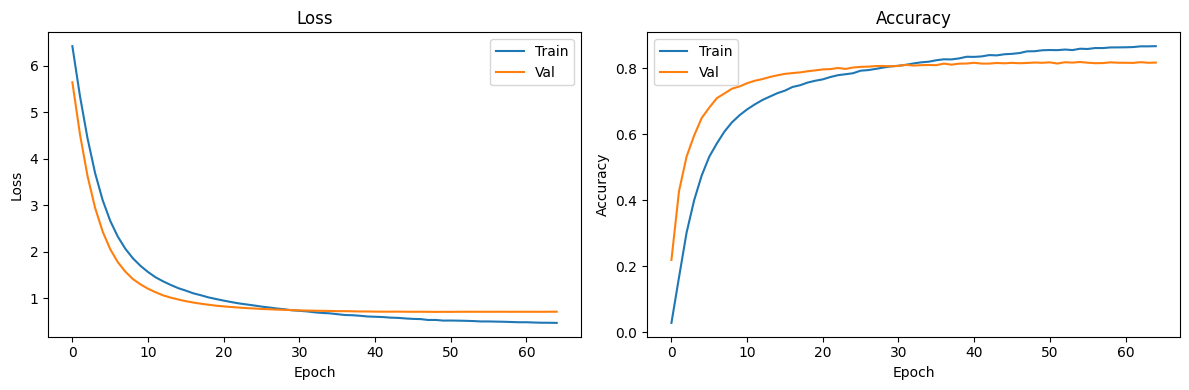

In [76]:
# Cell 14: Plot training curves

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history["train_loss"], label="Train")
ax1.plot(history["val_loss"], label="Val")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

ax2.plot(history["train_acc"], label="Train")
ax2.plot(history["val_acc"], label="Val")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

plt.tight_layout()
plt.savefig(CHECKPOINT_DIR / "training_curves.png", dpi=150)
plt.show()

In [80]:
# Cell 15: Test evaluation

checkpoint = torch.load(CHECKPOINT_DIR / "best_model.pt", weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f"\nTest Results:")
print(f"Loss:     {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Loaded best model from epoch 55

Test Results:
Loss:     0.6902
Accuracy: 0.8269 (82.69%)


In [81]:
# Cell 16: Save results

results = {
    "best_val_acc": best_val_acc,
    "test_acc": test_acc,
    "test_loss": test_loss,
    "epochs_trained": len(history["train_loss"]),
    "config": {
        "clip_model": "openai/clip-vit-base-patch32",
        "embedding_dim": EMBEDDING_DIM,
        "hidden_dims": HIDDEN_DIMS,
        "num_classes": NUM_CLASSES,
        "dropout": DROPOUT,
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "num_augmentations": NUM_AUGMENTATIONS
    }
}

with open(CHECKPOINT_DIR / "results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"Results saved to {CHECKPOINT_DIR / 'results.json'}")

Results saved to checkpoints_base32/results.json


## Part 3: Zero-shot Comparison & Inference

In [79]:
# Cell 17: Zero-shot CLIP baseline comparison

from transformers import CLIPModel, CLIPProcessor

# Load test embeddings
test_data = torch.load(EMBEDDING_DIR / "test_embeddings.pt", weights_only=True)
test_embeddings = test_data["embeddings"].to(DEVICE)
test_labels = test_data["labels"].to(DEVICE)

# Load label map
label_map = pd.read_csv(EMBEDDING_DIR / "label_map.csv")
landmark_names = label_map.sort_values("landmark_idx")["landmark_name"].tolist()

print(f"Test samples: {len(test_labels)}")
print(f"Classes: {len(landmark_names)}")

# Load CLIP for text encoding
print("\nLoading CLIP for zero-shot...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

# Create text embeddings
prompts = [f"a photo of {name}" for name in landmark_names]
inputs = clip_processor(text=prompts, return_tensors="pt", padding=True, truncation=True)
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

with torch.no_grad():
    text_embeddings = clip_model.get_text_features(**inputs)
    text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

print(f"Text embeddings shape: {text_embeddings.shape}")

# Zero-shot prediction
with torch.no_grad():
    similarity = test_embeddings @ text_embeddings.T
    zero_shot_preds = similarity.argmax(dim=-1)
    zero_shot_correct = (zero_shot_preds == test_labels).sum().item()
    zero_shot_acc = zero_shot_correct / len(test_labels)

print(f"\n{'='*50}")
print(f"Zero-shot CLIP accuracy: {zero_shot_acc:.4f} ({zero_shot_acc*100:.2f}%)")
print(f"Trained classifier accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"{'='*50}")
print(f"\nImprovement: +{(test_acc - zero_shot_acc)*100:.2f}% absolute")
print(f"Relative improvement: {((test_acc - zero_shot_acc) / zero_shot_acc)*100:.1f}%")

Test samples: 5628
Classes: 938

Loading CLIP for zero-shot...


/home/users/am1153/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Text embeddings shape: torch.Size([938, 512])

Zero-shot CLIP accuracy: 0.6469 (64.69%)
Trained classifier accuracy: 0.8269 (82.69%)

Improvement: +18.00% absolute
Relative improvement: 27.8%
